# News Reliability Predictor

2 years ago, a picture of my family member was taken from her social media account and used by a company to advertise their product, all without her consent. Through the investigation of this matter, I realized two critical things – first, that there is a severe lack of privacy and ethics in the social media domain and second, how misinformation and disinformation heavily restrict consumers from getting to reliable information, based on which they form an opinion. Although this incident piqued my interest because it happened to someone I know closely, it made me think deeply about the scale and impact of such incidents on hindering the advocation of social justice efforts. That is why, I aim to build a **"News Reliability Predictor"** which analyses the title, author name, and text of a news article and predicts if the article is a reliable or unreliable source of information.

## Introduction

This notebook analyses the data containing components of 20,000+ news articles and predicts if each of the articles is reliable or unreliable. The data is obtained from a Kaggle competition called [Fake News](https://www.kaggle.com/c/fake-news/data). It consists of:

1. train.csv - The data to be used for analyses and building an accurate model
2. test.csv - The data whose labels are unknown to us. The predictions are submitted to the kaggle forum, where the accuracy of our predictions are displayed. This gives an estimate of how well our model behaves on unseen data

Let's begin!

## Data Input

In [10]:
#importing relevant libraries for the analysis
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import textblob
import pandas as pd
import sklearn
import _pickle as cPickle
import numpy as np
import seaborn as sns
from nltk.util import ngrams
from nltk import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

In [11]:
#reading the train.csv file
df = pd.read_csv('train.csv')

In [6]:
#displaying the first 5 rows of the df
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
#describing the numeric data
df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [5]:
#Checking for the number of null or missing values in the data
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

It can be observed that:

1. There are two numeric columns, namely - id and label.
2. There are quite a lot of missing values in the data which will require removal of rows, or imputations of data.

Furthermore, we can define the columns of the dataframe as follows:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks the article as potentially unreliable
        1: unreliable
        0: reliable

Source: [Fake News](https://www.kaggle.com/c/fake-news/data)

## Exploratory Data Analysis

In [6]:
#are there any authors who only post fake news?
df.groupby(['author', 'label']).count().head(50)

,,id,title,text
author,label,,,
# 1 NWO Hatr,1,17,17,17
-NO AUTHOR-,1,54,54,54
10 Habits That Will Make Your Life Easier &amp; More Peaceful - Wellness Solutions,1,1,1,1
"10 More Beautiful Images That Remind You We Still Live In A Beautiful World, With Beautiful People - Upside Down Media",1,1,1,1
10 Movies That Could Change Your Understanding Of Life - Upside Down Media,1,1,1,1
10 Nutritious Foods That Help Reduce Asthma Attacks &amp; Boost Your Health - Health Alternative Solutions,1,1,1,1
10 Presidents &amp; Politicians Who Told Us That A “Secret Government” Controls The World &amp; What They Said - Upside Down Media,1,1,1,1
10 Shocking Facts About Society That We Absurdly Accept As Normal – Digital Flow,1,1,1,1
11 Things To Let Go Of Before The New Year,1,1,1,1


Text(0, 0.5, 'Frequency (%)')

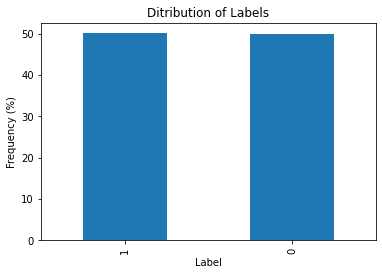

In [7]:
#label distribution
(df['label'].value_counts(normalize = True)*100).plot(kind = 'bar')
plt.title("Ditribution of Labels")
plt.xlabel("Label")
plt.ylabel("Frequency (%)")

## Data Cleaning

In [8]:
#identifying the missing values
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
#imputing missing author labels with "-NO AUTHOR-"
df.loc[df['author'].isna(), 'author'] = "-NO AUTHOR-"

In [10]:
#verification for missing values in author
df['author'].isna().sum()

0

In [11]:
#understanding distrubtion of title
df['title'].value_counts()

Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence    5
The Dark Agenda Behind Globalism And Open Borders                                                     5
What to Cook This Week - The New York Times                                                           4
“If Trump Loses, I’m Grabbing My Musket”: Former Congressman Ready to Go Full Revolution              4
The U.S. National Bird Is Now a Drone                                                                 4
                                                                                                     ..
One Treaty Could Change the Fight to Stop the Dakota Access Pipeline                                  1
Scott Pruitt, Trump’s E.P.A. Pick, Backed Industry Donors Over Regulators - The New York Times        1
Can the G.O.P. Senate Majority Survive Donald Trump? - The New York Times                             1
EU Gave Notre Dame Hammer Attack Jihadi Award For Writing Pro-Im

In [12]:
#checking if authors and text are missing together
display(df[df['title'].isna()])
display(df[df['text'].isna()])

,id,title,author,text,label
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
196,196,NaN,Raffie,They got the heater turned up on high.,1
...,...,...,...,...,...
20568,20568,NaN,Cathy Milne,"Amusing comment Gary! “Those week!” So, are ...",1
20627,20627,NaN,Ramona,"No she doesn’t have more money than God, every...",1
20636,20636,NaN,Dave Lowery,Trump all the way!,1
20771,20771,NaN,Letsbereal,DYN's Statement on Last Week's Botnet Attack h...,1


,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,-NO AUTHOR-,NaN,1
573,573,Le top des recherches Google passe en top des ...,-NO AUTHOR-,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,-NO AUTHOR-,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,-NO AUTHOR-,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,-NO AUTHOR-,NaN,1
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",-NO AUTHOR-,NaN,1
2793,2793,«Pourquoi je suis candidat à la présidentielle...,-NO AUTHOR-,NaN,1
3329,3329,GuinessBook : 100 millions d’Américains batten...,-NO AUTHOR-,NaN,1
3729,3729,Les Américains ne sont plus qu’à quelques heur...,-NO AUTHOR-,NaN,1
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,-NO AUTHOR-,NaN,1


In most cases where title is missing, the author and text is available.

In most cases where text is missing, the author and title is available.

Therefore, we choose to drop this data.

In [13]:
#dropping rows without title or text
df.dropna(inplace = True)

In [14]:
#verification for missing values
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [15]:
#dropping id from the dataframe as it is irrelevant to the analysis
df.drop(columns = 'id', inplace = True)

In [16]:
#displaying the first 5 rows of the data
df.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Text Analysis

Now, we begin the text analysis to understand if there are any specific words in the text which scream "FAKE NEWS!!"

In [17]:
#downloading stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nayankaushal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
#creating a function which returns a list containing the top ngrams of each row
def top_ngrams(df, n = 1):
    top_ngrams = []
    for text in df[df['label'] == 1]['text'].head(1000):
        #removing the stopwords
        words = " ".join([word for word in text.split(" ") if (word.lower() not in set(stopwords.words('english'))) and (word.isalpha())])
        #tokenizing the words
        token = word_tokenize(words)
        #taking the ngrams by specifying n value given by the user
        n_grams = ngrams(token, n)
        #getting the most common 3 words
        for x in Counter(n_grams).most_common(3):
            top_ngrams.append(x[0])
    return top_ngrams

In [19]:
#top unigrams
top_unigrams = top_ngrams(df, 1)

#top bigrams
top_bigrams = top_ngrams(df, 2)

Text(0, 0.5, 'Number of occurences')

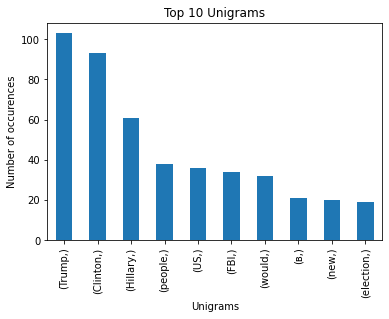

In [20]:
#displaying the top 10 unigrams
pd.DataFrame(top_unigrams, columns = ["unigrams"]).value_counts(sort = True).nlargest(10).plot(kind = 'bar')
plt.title("Top 10 Unigrams")
plt.xlabel("Unigrams")
plt.ylabel("Number of occurences")

Text(0, 0.5, 'Number of occurences')

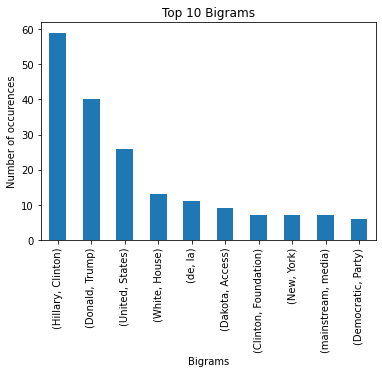

In [21]:
#displaying the top 10 bigramas
pd.DataFrame(top_bigrams, columns = ["bigrams_1", "bigrams_2"]).value_counts(sort = True).nlargest(10).plot(kind = 'bar')
plt.title("Top 10 Bigrams")
plt.xlabel("Bigrams")
plt.ylabel("Number of occurences")

## Modeling - Naive Bayes

In [22]:
#defining the function which splits the text into tokens
def split_into_tokens(text):
    return TextBlob(text).words

In [23]:
#defines the function which splits the text into lemmas - performing lemmatization
def split_into_lemmas(text):
    text = text.lower()
    words = TextBlob(text).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

#### Tinkering with parameters 1: Using df["text"] as the predictor variable

In [24]:
#splitting the dataset into train-test
msg_train, msg_test, label_train, label_test = train_test_split(df['text'], df['label'], test_size=0.2, shuffle = False)

#printing the length of the split data
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

16162 4041 20203


In [25]:
#constructing a pipeline to 
#1. split the words and perform lemmatization
#2. perform tfidf transformation
#3. Run a Multinomial Naive Bayes model
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [26]:
#Predicting the test labels by fitting the train labels in the Naive Bayes model
%time naive_bayes_1 = pipeline.fit(msg_train, label_train)
print('Confusion Matrix : \n')
predictions = naive_bayes_1.predict(msg_test)

#printing the confusion matrix, classification report, and test accuracy
print(confusion_matrix(label_test, predictions))
print(classification_report(label_test, predictions))
print(accuracy_score(label_test, predictions))

CPU times: user 2min 40s, sys: 1.19 s, total: 2min 41s
Wall time: 2min 42s
Confusion Matrix : 

[[2049    3]
 [ 821 1168]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2052
           1       1.00      0.59      0.74      1989

    accuracy                           0.80      4041
   macro avg       0.86      0.79      0.79      4041
weighted avg       0.85      0.80      0.79      4041

0.7960900767136847


We obtain a test data accuracy fo 79.6%, which is good to start with. This means that 79.6% of the labels in the test data were correctly classified as reliable or unreliable - when using just the news text as predictor variable.

In the next step, we will use the author and text variables as predictors because as we saw earlier, author name carries some weight in checking the reliability of the data

#### Tinkering with parameters 2: Using df["text"] and df["author"] as the predictor variables

In [27]:
#combine author name with text
df['text'] = df['author'] + " " + df['text']

In [28]:
#splitting the dataset into train-test
msg_train, msg_test, label_train, label_test = train_test_split(df['text'], df['label'], test_size=0.2, shuffle = False)

#printing the length of the split data
print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

16162 4041 20203


In [29]:
#Predicting the test labels by fitting the train labels in the Naive Bayes model
%time naive_bayes_2 = pipeline.fit(msg_train, label_train)
print('Confusion Matrix : \n')
predictions = naive_bayes_2.predict(msg_test)

#printing the confusion matrix, classification report, and test accuracy
print(confusion_matrix(label_test, predictions))
print(classification_report(label_test, predictions))
print(accuracy_score(label_test, predictions))

CPU times: user 2min 38s, sys: 1.03 s, total: 2min 39s
Wall time: 2min 40s
Confusion Matrix : 

[[2052    0]
 [ 751 1238]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2052
           1       1.00      0.62      0.77      1989

    accuracy                           0.81      4041
   macro avg       0.87      0.81      0.81      4041
weighted avg       0.86      0.81      0.81      4041

0.8141549121504578


We obtain a test data accuracy fo 81.41%, which is better than the one we received with just the text as predictor. Therefore, we can use this data for further modeling purposes.

Now that we have decided on which variables to use for modeling, we will perform a 5-fold cross validation to check for overfitting.

#### Tinkering with model 3: Performing 5-fold cross validation to check for overfitting of the model.

In [30]:
#performing 5-fold cross valdiation to check for overfitting
%time scores = cross_val_score(pipeline, msg_train, label_train, cv=5, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean(), scores.std())

CPU times: user 263 ms, sys: 777 ms, total: 1.04 s
Wall time: 4min 30s
[0.80111352 0.79987628 0.81899752 0.81373762 0.81064356]
0.8088737011266854 0.007354673134570766


We observe that the cross validation accuracy is very close to the test accuracy obtained in the previous models. Therefore, we can say that the model predicts the labels with an accuracy of 80.8%.

Another model which can be used for text analytics is a Support Vector Machine. Let's use SVM to predict if a news article is reliable or unreliable and check its accuracy.

## Modeling - Support Vector Machine

In [31]:
#constructing a pipeline to 
#1. split the words and perform lemmatization
#2. perform tfidf transformation
#3. Run a Support Vector model
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

#performing 5-fold cross valdiation to check for overfitting
%time scores = cross_val_score(pipeline, msg_train, label_train, cv=5, scoring='accuracy', n_jobs=-1)
print(scores)
print (scores.mean(), scores.std())

CPU times: user 193 ms, sys: 730 ms, total: 923 ms
Wall time: 11min 19s
[0.97494587 0.97309001 0.97493812 0.9740099  0.97586634]
0.9745700472846541 0.0009446017509894647


With the SVM model, we see a huge difference in the accuracy as compared to the one obtained with the Naive Bayes model. Hence, we will choose the SVM model for the predictions.

## Selecting Model with best accuracy - SVM

In [32]:
#Predicting the test labels by fitting the train labels in the SVM model
%time svm_detector = pipeline.fit(msg_train, label_train)
print('Confusion Matrix : \n')
predictions = svm_detector.predict(msg_test)

#printing the confusion matrix, classification report, and test accuracy
print(confusion_matrix(label_test, predictions))
print(classification_report(label_test, predictions))
print(accuracy_score(label_test, predictions))

CPU times: user 10min 24s, sys: 3.04 s, total: 10min 27s
Wall time: 17min 46s
Confusion Matrix : 

[[2023   29]
 [  48 1941]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2052
           1       0.99      0.98      0.98      1989

    accuracy                           0.98      4041
   macro avg       0.98      0.98      0.98      4041
weighted avg       0.98      0.98      0.98      4041

0.9809453105666914


Text(0.5, 0, 'Predicted label')

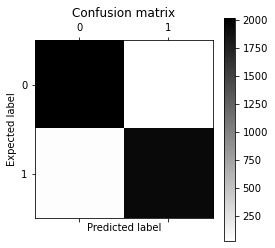

In [33]:
#plotting the confusion matrix
plt.matshow(confusion_matrix(label_test, predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Expected label')
plt.xlabel('Predicted label')

Now that we likely have an accurate model, we can fit the entire training dataset in it to further increase its accuracy.

## Final Model for Test Prediction

In [34]:
#fitting the entire training data into the model
%time svm_detector_final = pipeline.fit(df['text'], df['label'])

CPU times: user 15min 40s, sys: 5.39 s, total: 15min 45s
Wall time: 15min 47s


## Productionizing the Code

Storing the pickled file so that the model can be loaded onto other machines and used whenever required.

In [35]:
# store the news reliability detector to disk after training
with open('news_reliability_detector.pkl', 'wb') as fout:
    cPickle.dump(svm_detector_final, fout)

## Test Data Predictions

Now that the modeling is done, we will predict the test data accuracies and then submit the generated "submit.csv" file in order to check how well our model performs on unknown and unlabelled data.

In [36]:
#importing test.csv
test = pd.read_csv('test.csv')

In [37]:
#cleaning data
test.loc[test['text'].isna(), 'text'] = 'text not available'

In [38]:
#predicting labels for test data
test_predictions = svm_detector_final.predict(test['text'])
test['label'] = test_predictions

In [39]:
#exporting the submit.csv file for submission
test[['id', 'label']].set_index('id').to_csv('submit.csv')

Upon submitting the test data predictions on Kaggle, we observed an accuracy of **97.994%**. This means that our model is generalizable on unseen data and predicts if a news article is reliable or unreliable with a high accuracy. Here's a snippet of the Kaggle submission:

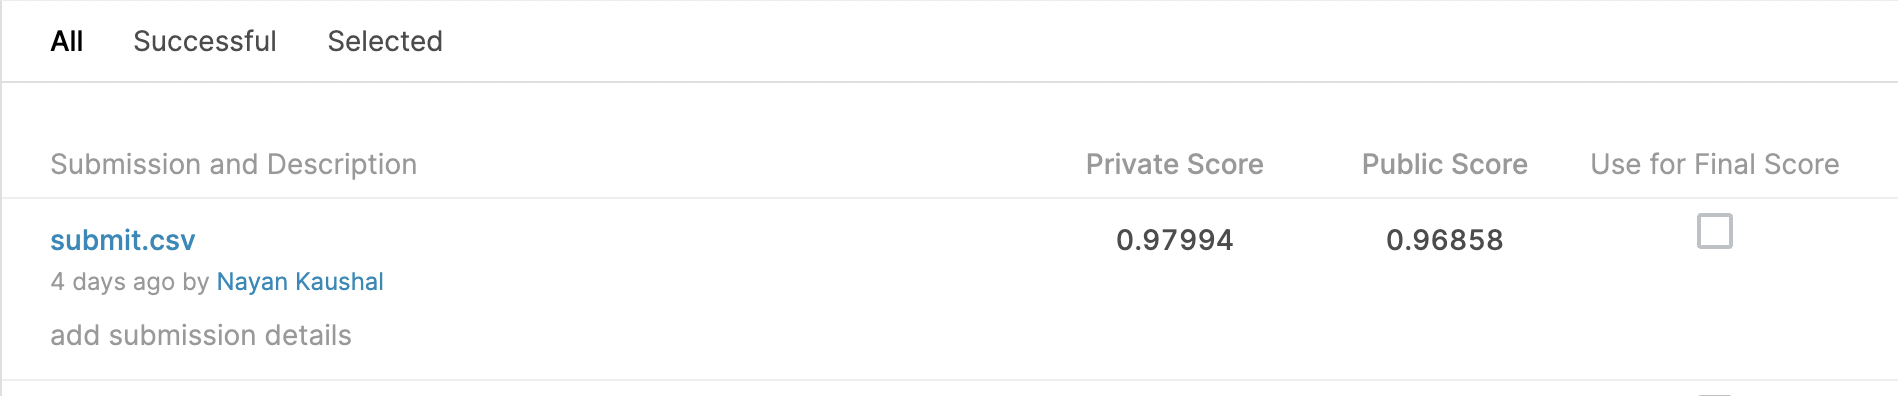

## Some Questions to Answer

#### Describe the dataset you chose. Why did you choose it? What features does it include? What year is it from? How was it collected? What should we know about this dataset as we read your writeup?

I have chosen the "Fake News" dataset which contains data of 20,800 news articles and labels - either 0 or 1 where 0 denotes reliable news and 1 denotes unreliable news. The dataset used for training is present in train.csv while the one used for testing (which is unlabelled) is test.csv.

2 years ago, a picture of my family member was taken from her social media account and used by a company to advertise their product, all without her consent. Through the investigation of this matter, I realized two critical things – first, that there is a severe lack of privacy and ethics in the social media domain and second, how misinformation and disinformation heavily restrict consumers from getting to reliable information, based on which they form an opinion. Although this incident piqued my interest because it happened to someone I know closely, it made me think deeply about the scale and impact of such incidents on hindering the advocation of social justice efforts. That is why, I chose this dataset to help curb the spread of misinformation and disinformation.

Following are the features that it includes:
1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks the article as potentially unreliable
        1: unreliable
        0: reliable

Source: [Fake News](https://www.kaggle.com/c/fake-news/data)

The dataset is from the year: **2014**

From the discussions posted in the Kaggle webpage of the dataset, it appears to have been collected from:
1. Web-Scraping news articles
2. Combining existing data on fake news

One important thing to note is that the dataset is huge. It contains 20,800 rows of news articles. This means that it has a large amount of content in each row. Therefore, the computations are taking longer than they should in case of an ideal model.

#### Define a research question. What are you trying to predict? Describe what you're trying to accomplish (it will differ between Supervised and Unsupervised learning).

Following is my research question:

**"Can we accurately predict if a news article is reliable or unreliable based on its text content?"**

I'm trying to predict if a set of news articles (test.csv data) are reliable or unreliable. The aim of this is to understand the model performance and see how well the model works on unseen and unlabelled data so that it can be productionized.

Through my efforts, I hope to accomplish a dip in the spread of misinformation so that important information like social justice issues reaches the public. In future, I want to build a system which informs the user on how reliable a news article is. This could be an essential asset in preventing the spread of misinformation.

#### Why is this algorithm a good way of answering your research question?

The algorithms I have chosen are Naive Bayes and Support Vector Machines. Both the algorithms are a good ways of answering my research questions for the following reasons:

1. With Naive Bayes, I get an accuracy of ~80%
2. With SVM, I get an accuracy of ~98%
3. Both models work well on high-dimensional data without being prone to overfitting
4. The research question aims to classify the data into one of the two groups and my algorithm helps in doing that.

#### Using the data you chose and the algorithm you chose, read in your data and run your model.

I have performed this action in the steps covered above. Please take a look at the notebook.

#### Tinker with parameters at least 3 times (changing learning rate, changing features, changing k like in KNN, etc). You may tinker with the same kind of parameter 3 times, it doesn't have to be 3 different parameters. (example: you can just tinker with k. k=1, k=3, or k=8) Or you might want to tinker with features and also your k value or whatever is appropriate for your algorithm.

I have performed this action in the steps covered above. Please take a look at the notebook.

#### Report the accuracy of your model. Either through RMSE or another metric. How did accuracy change with your parameter tinkering?

Tinkering 1: Using df["text"] as the predictor variable

Model accuracy = 79.6%

Tinkering 2: Using df["text"] and df["author"] as the predictor variables

Model accuracy = 81.41%

Tinkering 3: Performing 5-fold cross validation to check for overfitting of the model

Average Model accuracy = 80.8%

The accuracy increased by adding the "author" variable to the predictor variable. However, in order to be sure that this wasn't the result of overfitting, I performed 5-fold cross valdiation and received an accuracy of 80.8%.

#### Create a visualization demonstrating your findings. Make sure to include a title and axis labels. Describe what's being shown in your visualization.

While the visualizations of the top 10 unigrams and top 10 bigrams of training data are completed above, I will now visualize the same for test data and display the distributions of the predictions. Moreover, the confusion matrix of the results of the SVM model predictions is visualized above.

In [40]:
#top unigrams
top_unigrams = top_ngrams(test, 1)

#top bigrams
top_bigrams = top_ngrams(test, 2)

Text(0, 0.5, 'Number of occurences')

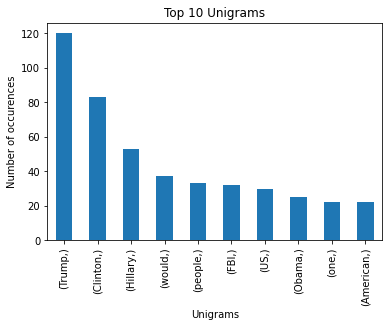

In [41]:
#displaying the top 10 unigrams
pd.DataFrame(top_unigrams, columns = ["unigrams"]).value_counts(sort = True).nlargest(10).plot(kind = 'bar')
plt.title("Top 10 Unigrams")
plt.xlabel("Unigrams")
plt.ylabel("Number of occurences")

Text(0, 0.5, 'Number of occurences')

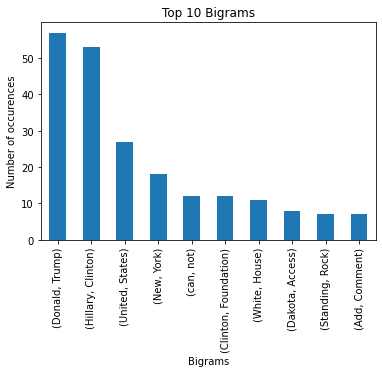

In [42]:
#displaying the top 10 bigrams
pd.DataFrame(top_bigrams, columns = ["bigrams_1", "bigrams_2"]).value_counts(sort = True).nlargest(10).plot(kind = 'bar')
plt.title("Top 10 Bigrams")
plt.xlabel("Bigrams")
plt.ylabel("Number of occurences")

Text(0, 0.5, 'Frequency (%)')

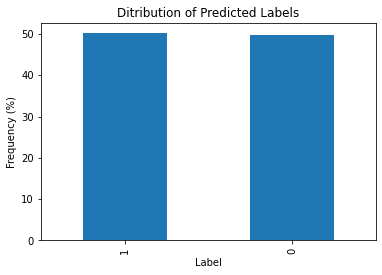

In [43]:
#Predictions label distribution
(test['label'].value_counts(normalize = True)*100).plot(kind = 'bar')
plt.title("Ditribution of Predicted Labels")
plt.xlabel("Label")
plt.ylabel("Frequency (%)")

From the visualizations above, we observe the top bigrams and unigrams of the unreliable news articles in the test data. This could mean that:
1. News articles are collected from within the United States which means that the model might fail to identify reliability of news articles of other countries
2. Most of the misinformation is being reported in the area of politics

#### What challenges did you run into? Do you think it was because of the data, the model, the research question? How would you overcome these challenges?

The biggest challenge that I ran into was the **high execution time** of the model pipeline. I believe that it was because of the data and the research question because the models that I've chosen have a high computation rate. 

Since there are approximately 16,000+ news article texts to be tokenized, lemmatized, and tf-idf processed, it takes long processing times for the text mining. Moreover, performing Multinomial Naive Bayes and SVM training on the resulting high-dimensional data would lead to higher execution times.

To overcome these challenges, I could have performed the text mining process once for the entire data without fitting it into a pipeline. Through this, the transformed data would be used for model training without having to be processed every time the pipeline was executed. In addition, I could reduce the length of the data but that would mean compromising on the model performance. However, if I perform the training on a small subset of the data and decide which model to choose, I can train it again with the same parameters on the entire dataset. I believe that implementing these two approaches would reduce the high execution time of the model training.

#### We learned a little bit about how our models can affect real people in the world. Name 2 potential benefits of your model and 2 potential harms. You can even look at the Wikipedia page on Algorithmic Bias (Links to an external site.) for inspiration. Every model has consequences, what can you think of? If your data is really not amenable to this question, simply write about any other example we covered in class, such as the Boston housing dataset or hate speech detectors.

Two potential benefits of the model:
1. On deployment of the model to a web-application, a user can input the url of the news application and check if the news is reliable or unreliable. This would help users in identifying misinformation and disinformation in news
2. The model would be useful in blocking potentially harmful websites which collect data of naive users through tricks. This would help in not only curbing misinformation spread but also preventing future information security issues.

Two potential harms of the model:
1. Although the model is trained on 20,000+ news articles data, it isn't certain if the articles are taken only from one geographical location like the United States. If so, then anybody using the model from another country might get the wrong output from the model and miss important information thinking that its unreliable.
2. The model wouldn't always predict every outcome correctly. This could be potentially harmful to the business of small-scale news companies if their articles are wrongly tagged as unreliable.

#### Name one research question you might ask next for future work (don't worry, you don't have to do it!) Why is it important?

For the future, I would ask the following research question:

**What are the ethical implications of the model?**

Although the model is being developed for social welfare and should be used for that purpose only, does it inadvertantly cause any social or ethical issues? Can we quantify its ethical implications, analyze the data, and find out to what extent the model's results can be justified ethically?

This is an important research question because I believe that solving one problem should not give rise to more problems.